# Statistical Analysis of Continuous Deck Blackjack

In [1]:
import itertools
import numpy as np

from collections import defaultdict
from matplotlib import pyplot as plt

from common.hand import Hand
from common.card import Card
from common.enums import PlayerAction, GameState
from simple_blackjack import Blackjack

from printer import print_best_actions

Let us run multiple simulations for each combination of hands that the player may have and face up card that the dealer may have.

By averaging the rewards of all simulations for a given (hand, dealers_hand, action), we can statistically deduce the optimal action for each starting condition.

Since many hands when HIT still require an additional action (such as HITing on a 13 and receiving a 2, resulting in a 15), we can reduce computational time by reusing the results from the new hand (in the case of the previous example, the reward we return is the average reward from 15). As such, we calculate the rewards for each hand in an order such that they can be reused by later hands.

In [2]:
hands = np.array([
    Hand([Card.TEN, Card.TEN, Card.ACE], wager=1),        # 21
    Hand([Card.TEN, Card.FIVE, Card.FIVE], wager=1),      # 20
    Hand([Card.TEN, Card.NINE], wager=1),                 # 19
    Hand([Card.TEN, Card.EIGHT], wager=1),                # 18
    Hand([Card.TEN, Card.SEVEN], wager=1),                # 17
    Hand([Card.TEN, Card.SIX], wager=1),                  # 16
    Hand([Card.TEN, Card.FIVE], wager=1),                 # 15
    Hand([Card.TEN, Card.FOUR], wager=1),                 # 14
    Hand([Card.TEN, Card.THREE], wager=1),                # 13
    Hand([Card.TEN, Card.TWO], wager=1),                  # 12
    Hand([Card.NINE, Card.TWO], wager=1),                 # 11
    Hand([Card.ACE, Card.TEN], wager=1),                  # Soft 21
    Hand([Card.EIGHT, Card.TWO], wager=1),                # 10
    Hand([Card.ACE, Card.NINE], wager=1),                 # Soft 20
    Hand([Card.SEVEN, Card.TWO], wager=1),                # 9
    Hand([Card.ACE, Card.EIGHT], wager=1),                # Soft 19
    Hand([Card.SIX, Card.TWO], wager=1),                  # 8
    Hand([Card.ACE, Card.SEVEN], wager=1),                # Soft 18
    Hand([Card.FIVE, Card.TWO], wager=1),                 # 7
    Hand([Card.ACE, Card.SIX], wager=1),                  # Soft 17
    Hand([Card.FOUR, Card.TWO], wager=1),                 # 6
    Hand([Card.ACE, Card.FIVE], wager=1),                 # Soft 16
    Hand([Card.THREE, Card.TWO], wager=1),                # 5
    Hand([Card.ACE, Card.FOUR], wager=1),                 # Soft 15
    Hand([Card.ACE, Card.THREE], wager=1),                # Soft 14
    Hand([Card.ACE, Card.TWO], wager=1),                  # Soft 13
    Hand([Card.ACE, Card.ACE], wager=1),                  # Soft 12
    Hand([Card.TEN, Card.TEN], wager=1),                  # Pair 10
    Hand([Card.NINE, Card.NINE], wager=1),                # Pair 9
    Hand([Card.EIGHT, Card.EIGHT], wager=1),              # Pair 8
    Hand([Card.SEVEN, Card.SEVEN], wager=1),              # Pair 7
    Hand([Card.SIX, Card.SIX], wager=1),                  # Pair 6
    Hand([Card.FIVE, Card.FIVE], wager=1),                # Pair 5
    Hand([Card.FOUR, Card.FOUR], wager=1),                # Pair 4
    Hand([Card.THREE, Card.THREE], wager=1),              # Pair 3
    Hand([Card.TWO, Card.TWO], wager=1)                   # Pair 2
])

dealers_hands = np.array([
    Hand([Card.ACE]),
    Hand([Card.TEN]),
    Hand([Card.NINE]),
    Hand([Card.EIGHT]),
    Hand([Card.SEVEN]),
    Hand([Card.SIX]),
    Hand([Card.FIVE]),
    Hand([Card.FOUR]),
    Hand([Card.THREE]),
    Hand([Card.TWO])
])

actions = np.array([
    PlayerAction.STAY,
    PlayerAction.HIT,
    PlayerAction.DOUBLE,
    PlayerAction.SPLIT
])

In [3]:
hand_to_idx_map = dict((h, i) for (i, h) in enumerate(hands))
dealers_hand_to_idx_map = dict((dh, i) for (i, dh) in enumerate(dealers_hands))
actions_to_idx_map = dict((a, i) for (i, a) in enumerate(actions))

In [5]:
def running_avg(avg, n, val):
    return (1 - 1.0 / n) * avg + 1.0 / n * val

def run_simulation(hand, dealers_hand, action, returns_cache, iters=1000):
    if not hand.can_perform_action(action): return
    
    hand_idx = hand_to_idx_map[hand]
    dealers_hand_idx = dealers_hand_to_idx_map[dealers_hand]
    action_idx = actions_to_idx_map[action]
    
    returns_cache[hand_idx][dealers_hand_idx][action_idx] = 0
    
    extra_wager = hand.wager if action in [PlayerAction.DOUBLE, PlayerAction.SPLIT] else None
    total_wager = hand.wager + (extra_wager or 0)
    
    for i in range(iters):
        game = Blackjack(state=GameState.PLAYING, 
                                 dealers_hand=dealers_hand, 
                                 hands=[hand], 
                                 hand=0)
        
        game_state, new_hands, _, _, reward = game.perform_action(action, wager=extra_wager)
        
        if (game_state == GameState.FINISHED):
            avg_return = returns_cache[hand_idx][dealers_hand_idx][action_idx]
            new_avg_return = running_avg(avg_return, i + 1, reward - total_wager)
            returns_cache[hand_idx][dealers_hand_idx][action_idx] = new_avg_return
        elif (game_state == GameState.PLAYING):
            left_hand_idx = hand_to_idx_map[new_hands[0]]
            reward = np.max(returns_cache[left_hand_idx][dealers_hand_idx])
            if (action == PlayerAction.SPLIT):
                right_hand_idx = hand_to_idx_map[new_hands[0]]
                reward += np.max(returns_cache[right_hand_idx][dealers_hand_idx])
            avg_return = returns_cache[hand_idx][dealers_hand_idx][action_idx]
            new_avg_return = running_avg(avg_return, i + 1, reward)
            returns_cache[hand_idx][dealers_hand_idx][action_idx] = new_avg_return
        else:
            raise ValueError('Unexpected GameState ' + game_state)

In [6]:
iters=1000
returns_cache = np.full((len(hands), len(dealers_hands), len(actions)), -np.inf)

for i in range(len(hands)):
    for j in range(len(dealers_hands)):
        for k in range(len(actions)):
            run_simulation(hands[i], dealers_hands[j], actions[k], returns_cache, iters)

In [7]:
hand_labels = np.array(['A A', '10 10', '9 9', '8 8', '7 7', '6 6', '5 5', '4 4', '3 3', '2 2', \
                        '21', '20', '19', '18', '17', '16', '15', '14', '13', '12', '11', '10', \
                        '9', '8', '7', '6', '5', 'A-9', 'A-8', 'A-7', 'A-6', 'A-5', 'A-4', 'A-3', 'A-2'])
dealers_hand_labels = np.array(['A', '10', '9', '8', '7', '6', '5', '4', '3', '2'])
action_labels = np.array(['S', 'H', 'D', 'SP'])
action_colours = np.array(['firebrick', 'greenyellow', 'gold', 'dodgerblue'])

chart_hand_idxes = [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, \
                    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, \
                    14, 16, 18, 20, 22, 13, 15, 17, 19, 21, 23, 24, 25]
chart_actions = returns_cache[chart_hand_idxes][:][:]
best_chart_actions = np.argmax(chart_actions, axis=2)

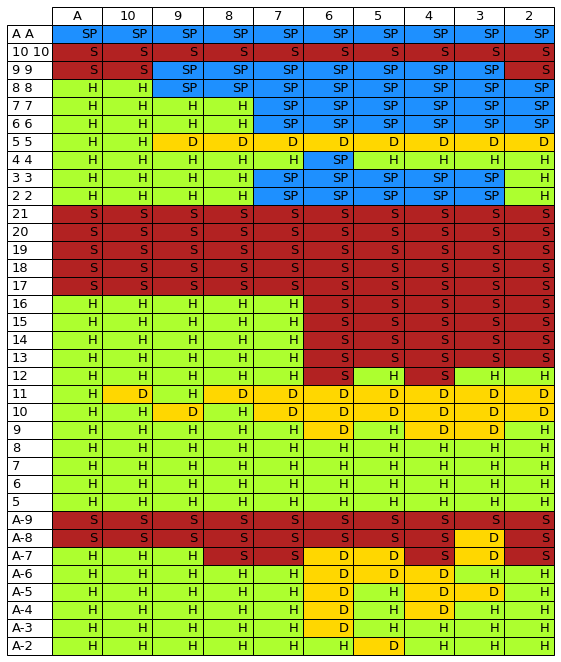

In [8]:
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=action_labels[best_chart_actions],
                 rowLabels=hand_labels,
                 colLabels=dealers_hand_labels,
                 cellColours=action_colours[best_chart_actions],
                 loc='center')

table.set_fontsize(13)
table.scale(1.5, 1.5)